# Проект: Анализ данных

# Название: Insights from Failed Orders

# Данные компании: Gett


[Сайт](https://platform.stratascratch.com/data-projects/insights-failed-orders)

<hr style="border: 2px solid green;" />

Gett (ранее GetTaxi), представляет собой разработанную в Израиле технологическую платформу, ориентированную исключительно на корпоративное управление наземным транспортом (GTM). У них есть приложение, где клиенты могут заказывать такси, а водители могут принимать их поездки (предложения). В момент, когда клиент нажимает кнопку «Заказать» в приложении, система ищет наиболее подходящих водителей и предлагает им заказ. 

**Цель:**
- Необходимо исследовать метрики сопоставления заказов (клиент-водитель), которые не были выполнены успешно, т. е. клиент не получил автомобиль.

**Структура проекта:**
1. Предобработка данных
2. Исследовательский анализ данных (EDA)
3. Визуализация гео данных (Построение карт)

**Задачи:**
- Выстроить распределение заказов по причинам отказа: отмены до и после назначения водителя. Выявить причины отмены заказа.  Проанализировать полученные данные, определить категорию, где больше всего заказов.
- Построить распределение невыполненных заказов по часам. Определить:
    - Есть ли тенденция, что определенные часы имеют аномально высокую долю той или иной категории.
    - Какие часы самые большие провалы. Как это можно объяснить.
- Построить график среднего времени до отмены с водителем и без него (по часам). 
- Построить график распределение среднего ETA по часам.
- Посчитать, сколько гексов размера 8 содержат 80% всех ордеров из исходных наборов данных. Визуализировать гексы, раскрасив их по количеству фейлов на карте. (Изпользую пакеты h3 и folium)

**Описание данных:**
Два набора данных: 

***data_orders***
- order_datetime - время заказа
- origin_longitude - долгота
- origin_latitude - широта 
- m_order_eta - время до прихода заказа
- order_gk - номер заказа
- order_status_key — статус отмены:
    - 4 - отменен клиентом,
    - 9 - отменен системой, т.е. отказ
- is_driver_assigned_key — назначен ли водитель
- Cancellation_time_in_seconds — количество секунд до отмены

***data_offers***
- order_gk - номер заказа, связанный с той же колонкой из набора данных заказов
- offer_id - ID оффера

<hr style="border: 2px solid green;" />

**Итоги исследования:**

**Распределение заказов по причинам отказа**

- **73% отмен (клиентом и системой), когда водитель не назначен**. 27% с назначенным водителем;
- **42.97% отмен совершено клиентами пока водитель не был назначен.** Стоит посмотреть время до отмены заказа, чтобы проверить предположение, что клиенты слишком долго ожидали назначение водителя. Кроме этого, стоит рассмотреть в какое время суток больше всего отмен;
- 30.28% заказов были отменены системой до назначения водителя;
- 26.74% заказов были отменены клиентами после назначения водителя;
- Всего 0.01% отменены системой после назначения водителя, вероятно техническая ошибка или нештатная ситуация с водителем.

**Распределение отмененных заказов по часам**

- Наибольшее количество отмен: наблюдаем пики в часы высокой нагрузки - 8 утра, 13, 15, 17 и 21 часов;
- С 5 утра количество отмен быстро возрастает, достигая пика к 8, затем падает к 10 часам утра. У нас нет данных относительно успешных заказов, но можно предположить, что это связано с увеличением общего количества заказов в часы пик (больше заказов - больше отмен). Отмены в нагруженное время могут быть по самым разным причинам;
- Отмены в разрезе статуса отмены (клиентом или системой): наблюдаем схожий тренд, в 8 утра больше всего отмен;
- Отмены в разрезе статуса назначения водителя (назначен или нет): отмены без назначения водителя имеют ярко выраженные пики в часы высокой загрузки. Интересно, что в промежуток с 10 до 11 утра количество отмен с назначением водителя больше.

**Среднее время с момента заказа до отмены**

- **Среднее время отмены с назначенным водителем составляет 157 сек, без - 121 сек.** Ожидаемо, что клиенты готовы ждать немного дольше, если водитель уже назначен;
- Интересно, что **наибольшее среднее время отмены с назначенным водителем с 23 ночи до 3 утра**. Вероятно, в это время мало водителей, клиенты готовы ждать;
- В часы пик, наоборот, среднее время ниже, можно предположить, что клиенты спешат по делам\на работу и ожидать долго не готовы.

**ETA - расчётное время прибытия:**

- Максимальное ETA в 8 утра. Вероятно, по причине высокой загрузки в час пик, а также большого разнообразия поездок по разным направлениям;
- Минимальное расчетное время прибытия в 4 утра. Интересно, что минимальное время и в 20 часов, в это время еще должна быть большая нагрузка дорогах.


<hr style="border: 2px solid green;" />

In [144]:
# Импорт библиотек

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import h3
import folium

import json
import geojson

#pip install geojson

#h3-py: Uber's H3 Hexagonal Hierarchical Geospatial Indexing System in Python

In [145]:
# Cбросим ограничения на количество выводимых столбцов
pd.set_option('display.max_columns', None)

# Настроим вывод всего текста
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [146]:
# Загрузка датасетов

offers = pd.read_csv(r'C:\Users\mirra\Desktop\Yandex.praktikum\Stratascratch\Insights from Failed Orders (GETT)\data_offers.csv')
orders  = pd.read_csv(r'C:\Users\mirra\Desktop\Yandex.praktikum\Stratascratch\Insights from Failed Orders (GETT)\data_orders.csv')

In [147]:
# Выведем необходимые данные с общей информацией

tables = {'orders':orders, 'offers':offers}


for name, table in tables.items():
    print(
        f'\n\033[1;30;46m_____________ДАТАСЕТ:  {name.upper()}_____________\033[0;0m\n',
        '\n\033[2;30;47m Вывод первых строк: \033[0;0m',
        )
    display(table.head(3))
    print('\n\033[2;30;47m Общая информация: \033[0;0m')
    display(table.info(memory_usage='deep'))
    print('\033[2;30;47m Подсчет доли пропусков в %: \033[0;0m')
    display(round(table.isnull().mean() * 100, 2))
    print(
        '\033[2;30;47m Подсчет дубликатов\033[0;0m', 
        '  ', round(table.duplicated().mean() * 100, 4),  ' %'
        )
    print('\n\033[2;30;47m Общая сводка строковых значений: \033[0;0m')
    try:
        display(table.describe(include=['object']).T)
    except:
        print('Датасет не содержит строковых значений')
    print('\n\033[2;30;47m Сводка числовых значений, включая даты: \033[0;0m')
    try:
        display(table.describe(datetime_is_numeric=True).T)
    except:
        print('Датасет не содержит числовых значений')
    print ('\n\033[01;30;46m_____________ОКОНЧАНИЕ ОТЧЕТА ПО ДАТАСЕТУ_____________\033[0;0m\n\n')


_____________ДАТАСЕТ:  ORDERS_____________
 
 Вывод первых строк: 


,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.98,51.46,60.00,3000583041974,4,1,198.00
1,20:57:32,-0.95,51.46,NaN,3000583116437,4,0,128.00
2,12:07:50,-0.97,51.46,477.00,3000582891479,4,1,46.00



 Общая информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 1.2 MB


None

 Подсчет доли пропусков в %: 


order_datetime                   0.00
origin_longitude                 0.00
origin_latitude                  0.00
m_order_eta                     73.74
order_gk                         0.00
order_status_key                 0.00
is_driver_assigned_key           0.00
cancellations_time_in_seconds   31.81
dtype: float64

 Подсчет дубликатов    0.0  %

 Общая сводка строковых значений: 


,count,unique,top,freq
order_datetime,10716,9921,23:36:03,4



 Сводка числовых значений, включая даты: 


,count,mean,std,min,25%,50%,75%,max
origin_longitude,10716.00,-0.96,0.02,-1.07,-0.97,-0.97,-0.95,-0.87
origin_latitude,10716.00,51.45,0.01,51.40,51.44,51.45,51.46,51.50
m_order_eta,2814.00,441.42,288.01,60.00,233.00,368.50,653.00,1559.00
order_gk,10716.00,3000598216166.14,23962605.03,3000550131545.00,3000583470351.75,3000594997547.00,3000623468170.75,3000632546049.00
order_status_key,10716.00,5.59,2.33,4.00,4.00,4.00,9.00,9.00
is_driver_assigned_key,10716.00,0.26,0.44,0.00,0.00,0.00,1.00,1.00
cancellations_time_in_seconds,7307.00,157.89,213.37,3.00,45.00,98.00,187.50,4303.00



_____________ОКОНЧАНИЕ ОТЧЕТА ПО ДАТАСЕТУ_____________



_____________ДАТАСЕТ:  OFFERS_____________
 
 Вывод первых строк: 


,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812



 Общая информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


None

 Подсчет доли пропусков в %: 


order_gk   0.00
offer_id   0.00
dtype: float64

 Подсчет дубликатов    0.0  %

 Общая сводка строковых значений: 
Датасет не содержит строковых значений

 Сводка числовых значений, включая даты: 


,count,mean,std,min,25%,50%,75%,max
order_gk,334363.00,3000601603689.09,24316377.25,3000551431542.00,3000584742529.00,3000596296260.00,3000625491451.00,3000633196222.00
offer_id,334363.00,300051539673.82,527682.11,300050591197.00,300051079663.50,300051561739.00,300051984772.50,300052444837.00



_____________ОКОНЧАНИЕ ОТЧЕТА ПО ДАТАСЕТУ_____________




In [148]:
# Объединим датасеты по колонке order_gk (номер заказа)
df = orders.merge(right=offers, how="inner", on="order_gk").reset_index()

In [149]:
df.sample(n=5, random_state=42)

,index,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
30194,30194,21:15:35,-0.97,51.46,299.00,3000555697076,4,1,223.00,300050725946
14748,14748,10:13:35,-0.96,51.43,NaN,3000626091676,4,0,91.00,300052014519
29083,29083,09:16:38,-1.03,51.44,NaN,3000594099225,4,0,68.00,300051458740
16926,16926,02:08:09,-0.97,51.44,NaN,3000626980467,4,0,125.00,300052031394
21530,21530,21:44:21,-0.97,51.46,NaN,3000554421440,4,0,11.00,300050671163


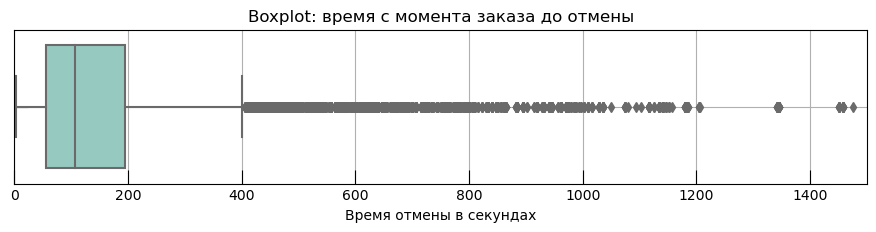

In [150]:
plt.figure(figsize = (11,2))

ax = sns.boxplot(x=df['cancellations_time_in_seconds'], palette='Set3')
plt.title('Boxplot: время с момента заказа до отмены')
plt.xlabel('Время отмены в секундах')
plt.grid()
plt.xlim(0, 1500)
ax.tick_params(direction="in", length=10)
ax.set_axisbelow(True);

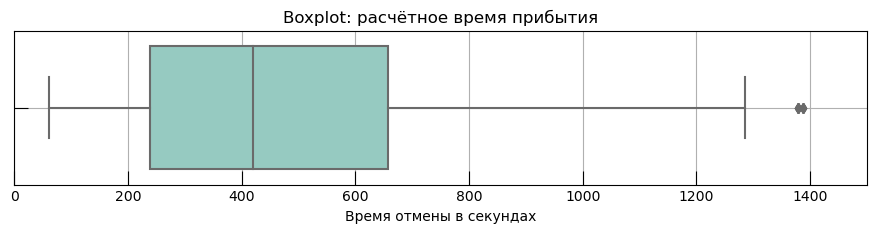

In [151]:
plt.figure(figsize = (11,2))

ax = sns.boxplot(x=df['m_order_eta'], palette='Set3')
plt.title('Boxplot: расчётное время прибытия')
plt.xlabel('Время отмены в секундах')
plt.grid()
plt.xlim(0, 1500)
ax.tick_params(direction="in", length=10)
ax.set_axisbelow(True);

**Выводы по датасету:**
- 74% пропусков в колонке (`m_order_eta`) с показателями метрики ETA (Estimated time of arrival);
- 32% пропусков в колонке `cancellations_time_in_seconds`;
- Полных дубликатов нет;
- Значения в колонке `m_order_eta` (время до прихода заказа) выглядят нормальными, нет очень больших значений. Самое длительное время ожидания заказа ~25 минут;
- Много выбросов в колонке `cancellations_time_in_seconds`, встречается аномальное время до отмены заказа  (~66 минут);
- Среднее время (с момента заказа до отмены): 163 сек (2.7 мин)

**Задачи:**
- На основе колонки `is_driver_assigned_key` создадим колонку `is_driver_assigned` с указанием назначен водитель или нет;
- На основе колонки `order_status_key` создадим колонку `order_status` с указанием статуса отмены;
- Для удобства переименуем колонку `order_datetime` в `order_time`;
- На основе колонки `order_time` создадим колонку `order_hour` с указанием часа заказа;


<hr style="border: 2px solid green;" />

## 1. Предобработка данных

x = np.where (condition, value_if_true, value_if_false)

In [152]:
df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Да", "Нет")
df["order_status"] = np.where(df["order_status_key"] == 4, "Отменен_клиентом", "Отменен_системой")

df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)

In [153]:
df = df.rename(columns={"order_datetime": "order_time"})

# Преобразуем колонку order_time - выделим час заказа
df["order_hour"] = df["order_time"].str.split(":").apply(lambda split: split[0])

In [154]:
df.sample(n=10, random_state=42)

,index,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,order_hour
30194,30194,21:15:35,-0.97,51.46,299.00,3000555697076,223.00,300050725946,Да,Отменен_клиентом,21
14748,14748,10:13:35,-0.96,51.43,NaN,3000626091676,91.00,300052014519,Нет,Отменен_клиентом,10
29083,29083,09:16:38,-1.03,51.44,NaN,3000594099225,68.00,300051458740,Нет,Отменен_клиентом,09
16926,16926,02:08:09,-0.97,51.44,NaN,3000626980467,125.00,300052031394,Нет,Отменен_клиентом,02
21530,21530,21:44:21,-0.97,51.46,NaN,3000554421440,11.00,300050671163,Нет,Отменен_клиентом,21
13008,13008,03:03:45,-0.97,51.45,NaN,3000593295623,NaN,300051413313,Нет,Отменен_системой,03
2034,2034,14:41:22,-0.95,51.45,NaN,3000584916226,6.00,300051090742,Нет,Отменен_клиентом,14
2229,2229,20:54:03,-0.99,51.48,NaN,3000585716553,NaN,300051125957,Нет,Отменен_системой,20
16632,16632,18:06:17,-0.95,51.44,NaN,3000627382471,113.00,300052078801,Нет,Отменен_клиентом,18
18189,18189,07:52:29,-0.97,51.46,479.00,3000587781360,47.00,300051178628,Да,Отменен_клиентом,07


<hr style="border: 2px solid green;" />

## 2. Исследовательский анализ данных (EDA)

### Распределение заказов по причинам отказа: отмена до и после назначения водителя. 

In [155]:
driver_assigned = df.groupby(['is_driver_assigned'])['order_gk'].count().to_frame().reset_index()

# Доля 
driver_assigned['share'] = (driver_assigned['order_gk'] / driver_assigned['order_gk'].sum()).round(4) *100
driver_assigned.sort_values(by='share', ascending=False)

,is_driver_assigned,order_gk,share
1,Нет,22904,73.25
0,Да,8364,26.75


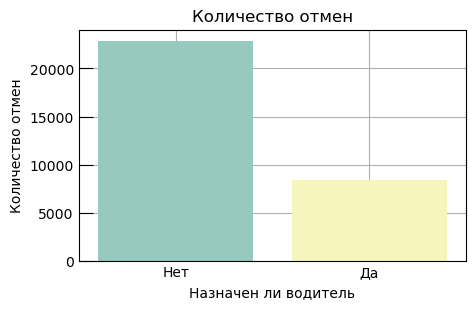

In [156]:
plt.figure(figsize = (5,3))

ax = sns.barplot(y='order_gk', x= 'is_driver_assigned', 
                 data=df.groupby(['is_driver_assigned'])['order_gk'].count()
                 .to_frame()
                 .reset_index()
                 .sort_values(by='order_gk', ascending=False), 
                 palette='Set3')
plt.title('Количество отмен')
plt.xlabel('Назначен ли водитель')
plt.ylabel('Количество отмен')
plt.grid()
ax.tick_params(direction="in", length=10)
ax.set_axisbelow(True);

In [157]:
status_share = df.groupby(['is_driver_assigned', 'order_status'])['order_gk'].count().to_frame().reset_index()

# Доля 
status_share['share'] = (status_share['order_gk'] / status_share['order_gk'].sum()).round(4) *100
status_share.sort_values(by='share', ascending=False)

,is_driver_assigned,order_status,order_gk,share
2,Нет,Отменен_клиентом,13435,42.97
3,Нет,Отменен_системой,9469,30.28
0,Да,Отменен_клиентом,8360,26.74
1,Да,Отменен_системой,4,0.01


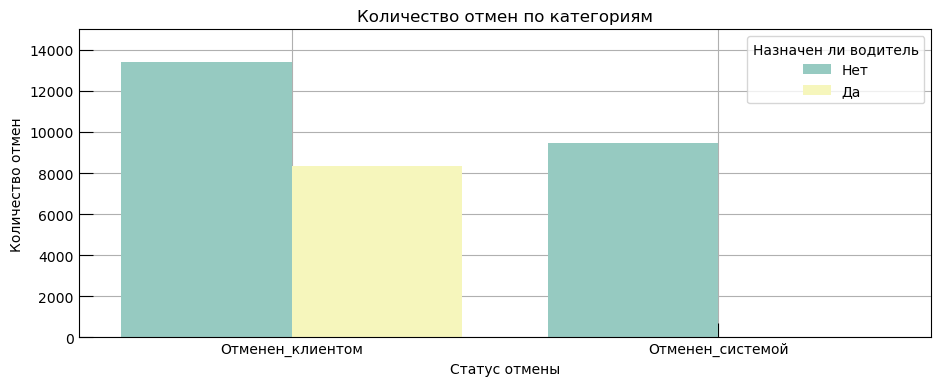

In [158]:
plt.figure(figsize = (11,4))

ax = sns.barplot(y='order_gk', x= 'order_status', 
                 data=df.groupby(['is_driver_assigned', 'order_status'])['order_gk'].count()
                 .to_frame()
                 .reset_index()
                 .sort_values(by='order_gk', ascending=False), 
                 hue = 'is_driver_assigned', 
                 palette='Set3')
plt.title('Количество отмен по категориям')
plt.xlabel('Статус отмены')
plt.ylabel('Количество отмен')
plt.legend(title='Назначен ли водитель', loc='upper right')
plt.grid()
plt.ylim(0, 15000)
ax.tick_params(direction="in", length=10)
ax.set_axisbelow(True);

### Выводы:

- **73% отмен (клиентом и системой), когда водитель не назначен**. 27% с назначенным водителем;
- **42.97% отмен совершено клиентами пока водитель не был назначен.** Стоит посмотреть время до отмены заказа, чтобы проверить предположение, что клиенты слишком долго ожидали назначение водителя. Кроме этого, стоит рассмотреть в какое время суток больше всего отмен;
- 30.28% заказов были отменены системой до назначения водителя;
- 26.74% заказов были отменены клиентами после назначения водителя;
- Всего 0.01% отменены системой после назначения водителя, вероятно техническая ошибка или нештатная ситуация с водителем.

<hr style="border: 2px solid green;" />

### Распределение отмененных заказов по часам

Определить:
- Есть ли тенденция, что определенные часы имеют аномально высокую долю отказов в той или иной категории.
- В какие часы больше всего отказов.

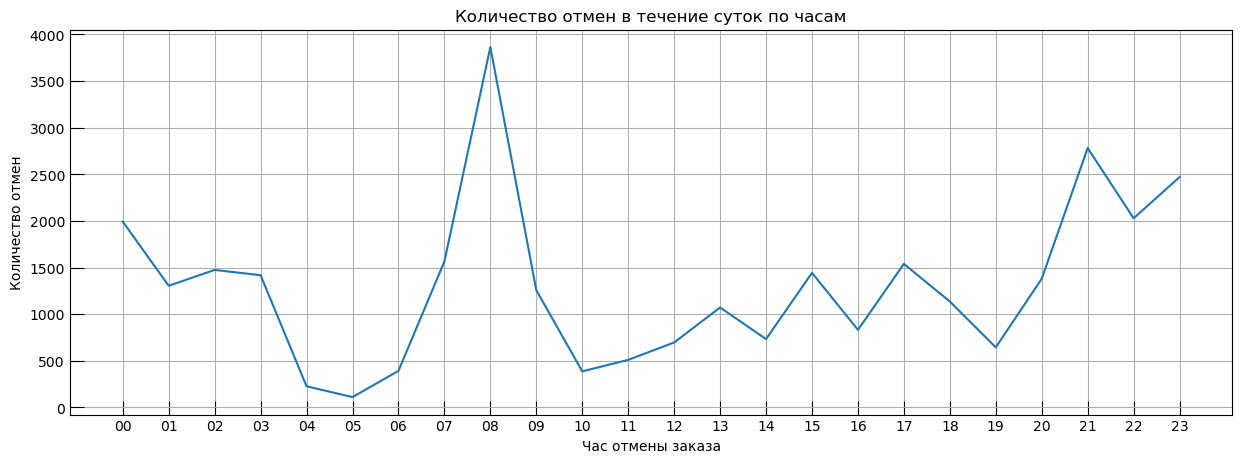

In [159]:
plt.figure(figsize = (15,5))

ax = sns.lineplot(y='order_gk', x= 'order_hour', 
                 data=df.groupby(by="order_hour")["order_gk"].count()
                 .to_frame()
                 .reset_index(), 
                 palette="flare")
plt.title('Количество отмен в течение суток по часам')
plt.xlabel('Час отмены заказа')
plt.ylabel('Количество отмен')
plt.grid()
ax.tick_params(direction="in", length=10)
ax.set_axisbelow(True);

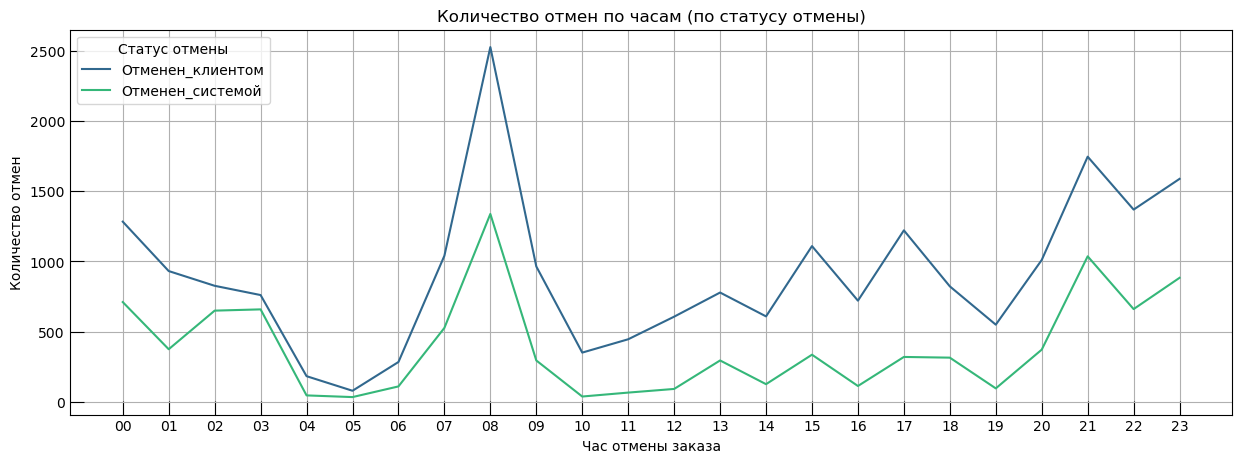

In [160]:
plt.figure(figsize = (15,5))

ax = sns.lineplot(y='order_gk', x= 'order_hour', 
                 data=df.groupby(by=["order_hour", "order_status"])["order_gk"].count()
                 .to_frame()
                 .reset_index(), 
                 hue = 'order_status', 
                 palette='viridis')
plt.title('Количество отмен по часам (по статусу отмены)')
plt.xlabel('Час отмены заказа')
plt.ylabel('Количество отмен')
plt.legend(title='Статус отмены', loc='upper left')
plt.grid()
ax.tick_params(direction="in", length=10)
ax.set_axisbelow(True);

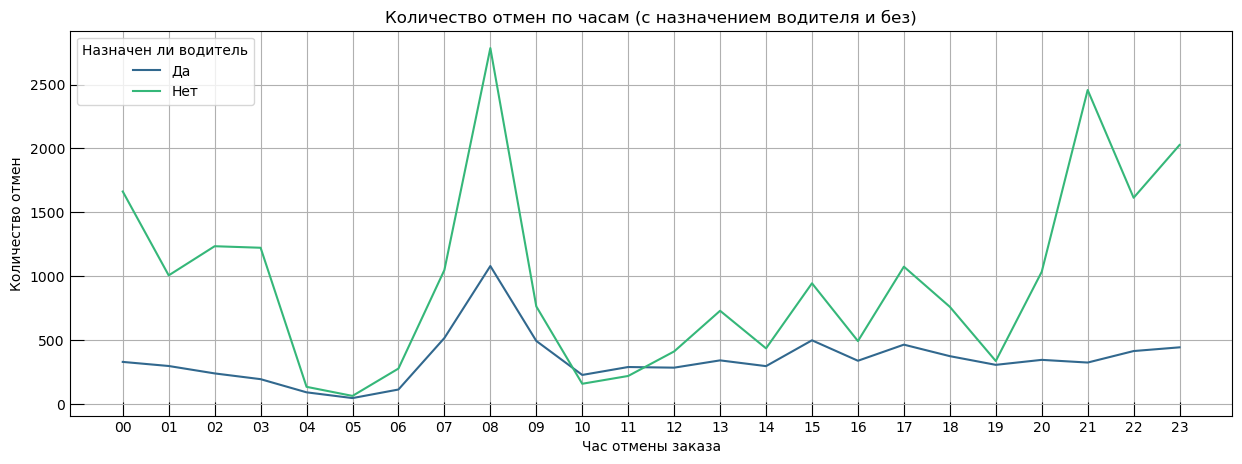

In [161]:
plt.figure(figsize = (15,5))

ax = sns.lineplot(y='order_gk', x= 'order_hour', 
                 data=df.groupby(by=["order_hour", "is_driver_assigned"])["order_gk"].count()
                 .to_frame()
                 .reset_index(), 
                 hue="is_driver_assigned", 
                 palette='viridis')
plt.title('Количество отмен по часам (с назначением водителя и без)')
plt.xlabel('Час отмены заказа')
plt.ylabel('Количество отмен')
plt.legend(title='Назначен ли водитель', loc='upper left')
plt.grid()
ax.tick_params(direction="in", length=10)
ax.set_axisbelow(True);

### Выводы:

- Наибольшее количество отмен: наблюдаем пики в часы высокой нагрузки - 8 утра, 13, 15, 17 и 21 часов;
- С 5 утра количество отмен быстро возрастает, достигая пика к 8, затем падает к 10 часам утра. У нас нет данных относительно успешных заказов, но можно предположить, что это связано с увеличением общего количества заказов в часы пик (больше заказов - больше отмен). Отмены в нагруженное время могут быть по самым разным причинам;
- Отмены в разрезе статуса отмены (клиентом или системой): наблюдаем схожий тренд, в 8 утра больше всего отмен;
- Отмены в разрезе статуса назначения водителя (назначен или нет): отмены без назначения водителя имеют ярко выраженные пики в часы высокой загрузки. Интересно, что в промежуток с 10 до 11 утра количество отмен с назначением водителя больше. 


<hr style="border: 2px solid green;" />

### Среднее время с момента заказа до отмены (в разрезе по часам)

In [162]:
df['cancellations_time_in_seconds'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 31268 entries, 0 to 31267
Series name: cancellations_time_in_seconds
Non-Null Count  Dtype  
--------------  -----  
21795 non-null  float64
dtypes: float64(1)
memory usage: 244.4 KB


In [163]:
# Определяем верхнюю и нижнюю границу выбросов
# т.к. percentile() рассматривает Nan, как наибольшие и наименьшие значения - исключим их
print(np.percentile(df.query('cancellations_time_in_seconds == cancellations_time_in_seconds')['cancellations_time_in_seconds'], [5, 95]))

[ 21. 575.]


In [164]:
cancel_time = df.query('21 < cancellations_time_in_seconds < 575')
cancel_time.groupby('is_driver_assigned')['cancellations_time_in_seconds'].mean().reset_index()

,is_driver_assigned,cancellations_time_in_seconds
0,Да,157.74
1,Нет,121.08


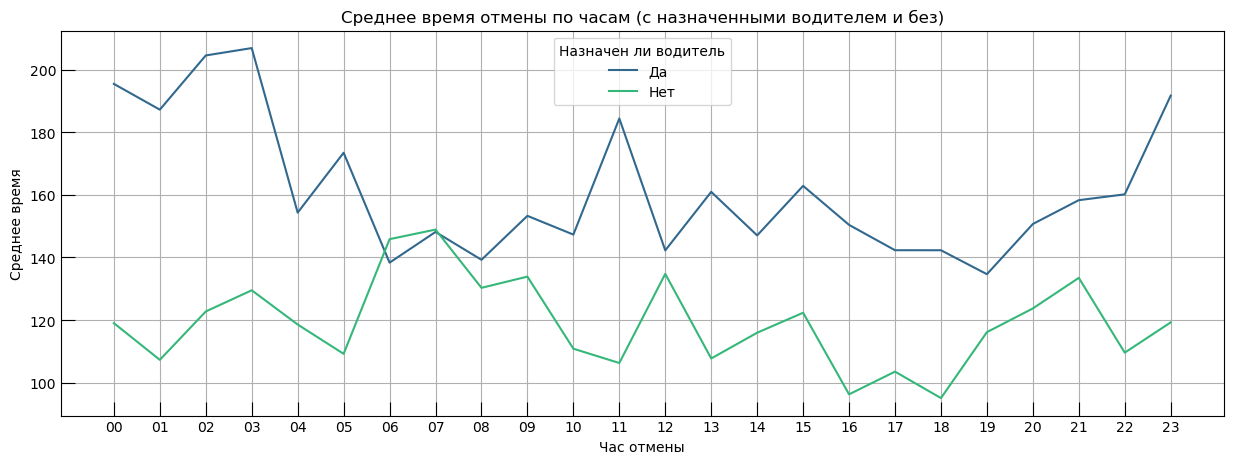

In [165]:
plt.figure(figsize = (15,5))

ax = sns.lineplot(y='cancellations_time_in_seconds', x= 'order_hour', 
                 data=cancel_time.groupby(by=["order_hour", "is_driver_assigned"])["cancellations_time_in_seconds"].mean()
                 .to_frame()
                 .reset_index(), 
                 hue = 'is_driver_assigned', 
                 palette='viridis')
plt.title('Среднее время отмены по часам (с назначенными водителем и без)')
plt.xlabel('Час отмены')
plt.ylabel('Среднее время')
plt.legend(title='Назначен ли водитель', loc='upper center')
plt.grid()
ax.tick_params(direction="in", length=10)
ax.set_axisbelow(True);

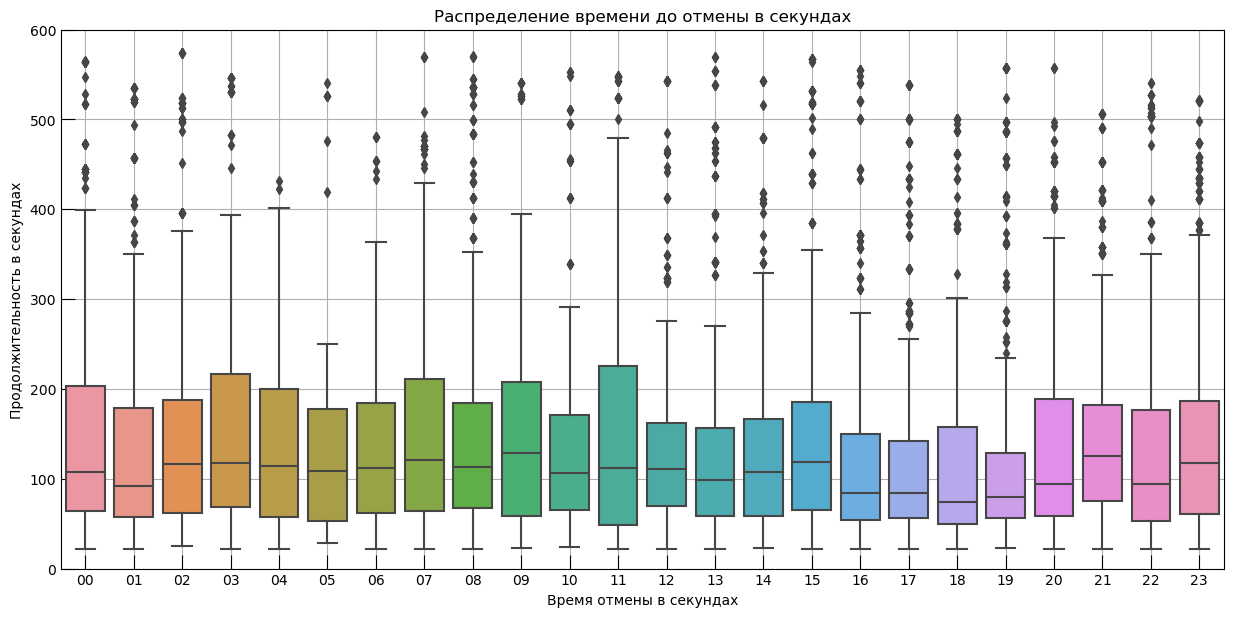

In [166]:
plt.figure(figsize = (15,7))

ax = sns.boxplot(data=cancel_time,
            x=cancel_time["order_hour"].sort_values(), 
            y="cancellations_time_in_seconds")
plt.title('Распределение времени до отмены в секундах')
plt.xlabel('Время отмены в секундах')
plt.ylabel('Продолжительность в секундах')
plt.ylim(0, 600)
plt.grid()
ax.tick_params(direction="in", length=10)
ax.set_axisbelow(True);

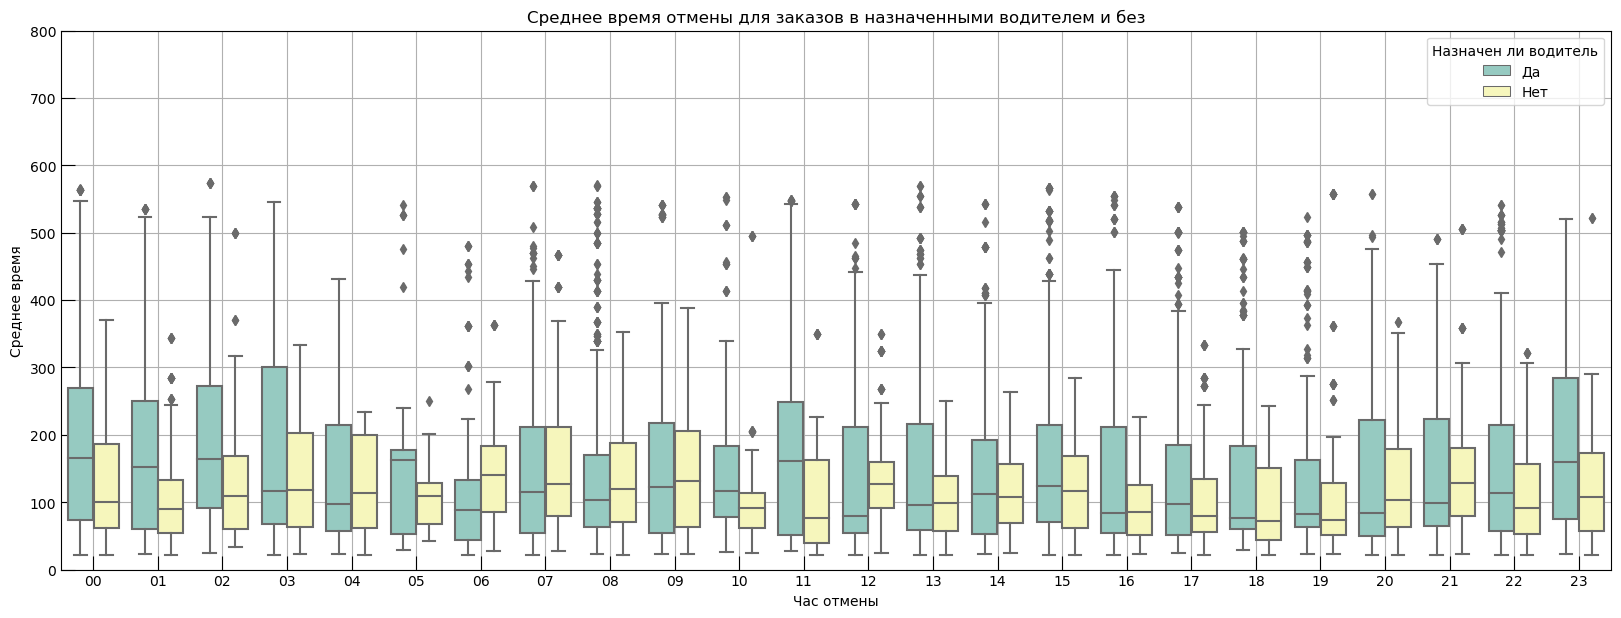

In [167]:
plt.figure(figsize = (20,7))

ax = sns.boxplot(data=cancel_time,
            x=cancel_time["order_hour"].sort_values(), 
            y="cancellations_time_in_seconds", 
            hue="is_driver_assigned",
            palette='Set3')
plt.title('Среднее время отмены для заказов в назначенными водителем и без')
plt.xlabel('Час отмены')
plt.ylabel('Среднее время')
plt.legend(title='Назначен ли водитель', loc='upper right')
plt.ylim(0, 800)
plt.grid()
ax.tick_params(direction="in", length=10)
ax.set_axisbelow(True);

### Выводы:

- В колонке `cancellations_time_in_seconds` наблюдаем довольно много выбросов, максимальное время до отмены заказа почти 66 минут;
- Ожидаемо, что больше всего аномальных значений в часы пик - 6 и 8 утра, а таже в 13, 15 и с 17 до 19 часов;
- Верхняя и нижняя граница выбросов - 21 сек. и 575 сек.;

- **Среднее время отмены с назначенным водителем составляет 157 сек, без - 121 сек.** Ожидаемо, что клиенты готовы ждать немного дольше, если водитель уже назначен;
- Интересно, что **наибольшее среднее время отмены с назначенным водителем с 23 ночи до 3 утра**. Вероятно, в это время мало водителей, клиенты готовы ждать;
- В часы пик, наоборот, среднее время ниже, можно предположить, что клиенты спешат по делам\на работу и ожидать долго не готовы. 


<hr style="border: 2px solid green;" />

### Среднего ETA по часам

**ETA (англ. Estimated time of arrival) — расчётное время прибытия**

In [168]:
# Определяем верхнюю и нижнюю границу выбросов
# т.к. percentile() рассматривает Nan, как наибольшие и наименьшие значения - исключим их
print(np.percentile(df.query('m_order_eta == m_order_eta')['m_order_eta'], [5, 95]))

[ 60. 958.]


In [169]:
eta = df.query('60 < m_order_eta < 958')
eta.groupby('is_driver_assigned')['m_order_eta'].mean().reset_index()

,is_driver_assigned,m_order_eta
0,Да,456.96


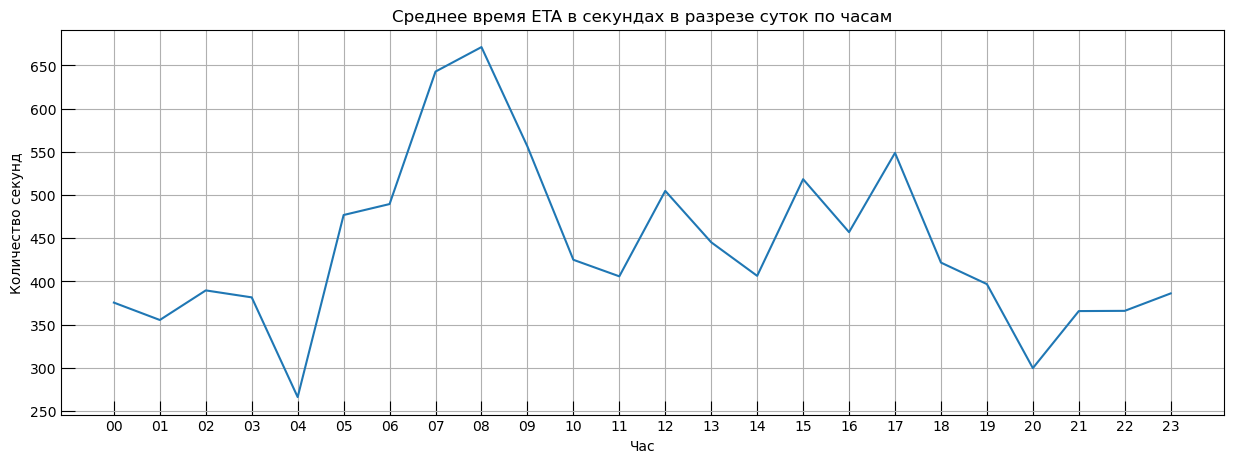

In [170]:
plt.figure(figsize = (15,5))

ax = sns.lineplot(y='m_order_eta', x= 'order_hour', 
                 data=df.groupby(by="order_hour")["m_order_eta"].mean()
                 .to_frame()
                 .reset_index(), 
                 palette="Set3")
plt.title('Среднее время ETA в секундах в разрезе суток по часам')
plt.xlabel('Час')
plt.ylabel('Количество секунд')
plt.grid()
ax.tick_params(direction="in", length=10)
ax.set_axisbelow(True);

### Выводы:

- Максимальное ETA в 8 утра. Вероятно, по причине высокой загрузки в час пик, а также большого разнообразия поездок по разным направлениям;
- Минимальное расчетное время прибытия в 4 утра. Интересно, что минимальное время и в 20 часов, в это время еще должна быть большая нагрузка дорогах.

<hr style="border: 2px solid green;" />

## 3. Визуализация гео данных 

### Cколько гексагонов содержат 80% всех заказов (пакеты h3 и folium)

https://towardsdatascience.com/uber-h3-for-data-analysis-with-python-1e54acdcc908

https://www.kaggle.com/code/firuzjuraev/charopleth-map-uber-pickups-in-new-york-city/notebook

In [171]:
df["hex_id"] = df.apply(
    func=lambda row: h3.geo_to_h3(lat=row['origin_latitude'], lng=row['origin_longitude'], resolution=8), axis=1)

In [172]:
hexes = df.groupby(by='hex_id')['order_gk'].count()
print(hexes.shape)

(139,)


In [173]:
hexes = hexes.reset_index()
hexes.sample(n=5, random_state=42)

,hex_id,order_gk
135,88195d74d1fffff,1
66,88195d2a33fffff,12
31,88195d2941fffff,52
118,88195d2b5dfffff,31
42,88195d2961fffff,5


In [174]:
hexes = hexes.sort_values(by='order_gk')  
total_orders = hexes['order_gk'].sum()  
hexes['cum_sum'] = hexes['order_gk'].cumsum() 
hexes['cum_perc'] = 100 * hexes['cum_sum'] / total_orders  
hexes[hexes['cum_perc'] <= 80].head()

,hex_id,order_gk,cum_sum,cum_perc
137,88195d74d5fffff,1,1,0.00
135,88195d74d1fffff,1,2,0.01
79,88195d2aebfffff,1,3,0.01
11,88195d282bfffff,1,4,0.01
122,88195d3993fffff,1,5,0.02


In [175]:
print(hexes.shape)
print(hexes[hexes['cum_perc'] <= 80].shape)

(139, 4)
(137, 4)


In [176]:
map = folium.Map(location=[df["origin_latitude"].mean(), df["origin_longitude"].mean()],
                 zoom_start=8.5,  
                 tiles='cartodbpositron')

In [177]:
def to_geojson(row):
    geometry = {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]
    }
    return geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"order_gk": row["order_gk"]})


geojsons = hexes.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))

In [178]:
# instantiate a colormap object for better visualisation
colormap = matplotlib.cm.get_cmap(name="plasma")
max_order_gk = hexes["order_gk"].max()
min_order_gk = hexes["order_gk"].min()

In [179]:
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
    "fillColor": matplotlib.colors.to_hex(
        colormap((f["properties"]["order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))),
    "color": "black",
    "weight": 1,
    "fillOpacity": 0.7
}).add_to(map)

In [180]:
map

### Выводы:

- 137 шестиугольников содержат около 80% данных, и только 2 шестиугольника содержат остальные 20%

<hr style="border: 2px solid green;" />

## Итоговый вывод по проекту:

В объединенном датасете содержатся данные про отмененные заказы.

**Распределение заказов по причинам отказа**

- **73% отмен (клиентом и системой), когда водитель не назначен**. 27% с назначенным водителем;
- **42.97% отмен совершено клиентами пока водитель не был назначен.** Стоит посмотреть время до отмены заказа, чтобы проверить предположение, что клиенты слишком долго ожидали назначение водителя. Кроме этого, стоит рассмотреть в какое время суток больше всего отмен;
- 30.28% заказов были отменены системой до назначения водителя;
- 26.74% заказов были отменены клиентами после назначения водителя;
- Всего 0.01% отменены системой после назначения водителя, вероятно техническая ошибка или нештатная ситуация с водителем.

**Распределение отмененных заказов по часам**

- Наибольшее количество отмен: наблюдаем пики в часы высокой нагрузки - 8 утра, 13, 15, 17 и 21 часов;
- С 5 утра количество отмен быстро возрастает, достигая пика к 8, затем падает к 10 часам утра. У нас нет данных относительно успешных заказов, но можно предположить, что это связано с увеличением общего количества заказов в часы пик (больше заказов - больше отмен). Отмены в нагруженное время могут быть по самым разным причинам;
- Отмены в разрезе статуса отмены (клиентом или системой): наблюдаем схожий тренд, в 8 утра больше всего отмен;
- Отмены в разрезе статуса назначения водителя (назначен или нет): отмены без назначения водителя имеют ярко выраженные пики в часы высокой загрузки. Интересно, что в промежуток с 10 до 11 утра количество отмен с назначением водителя больше.

**Среднее время с момента заказа до отмены**

- **Среднее время отмены с назначенным водителем составляет 157 сек, без - 121 сек.** Ожидаемо, что клиенты готовы ждать немного дольше, если водитель уже назначен;
- Интересно, что **наибольшее среднее время отмены с назначенным водителем с 23 ночи до 3 утра**. Вероятно, в это время мало водителей, клиенты готовы ждать;
- В часы пик, наоборот, среднее время ниже, можно предположить, что клиенты спешат по делам\на работу и ожидать долго не готовы.

**ETA - расчётное время прибытия:**

- Максимальное ETA в 8 утра. Вероятно, по причине высокой загрузки в час пик, а также большого разнообразия поездок по разным направлениям;
- Минимальное расчетное время прибытия в 4 утра. Интересно, что минимальное время и в 20 часов, в это время еще должна быть большая нагрузка дорогах.
